## Set up the environment

In [1]:
import pandas as pd
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
from src.plotting import trim_axs
pd.set_option('display.max_rows', None)


In [2]:
top_dir = '/Users/emcmaho7/Dropbox/projects/SI_fmri/SIfMRI_modeling'
interim_dir = f'{top_dir}/data/interim'

## Model comparisons

In [3]:
scores = []

files = glob(f'{interim_dir}/VisionEncoding/*.csv')
for file in files:
    df = pd.read_csv(file)
    df['model_uid'] = file.split('/')[-1].split('.csv')[0]
    scores.append(df)

files = glob(f'{interim_dir}/LLMEncoding/*corrected_unmasked.csv')
for file in files:
    df = pd.read_csv(file)
    df['model_uid'] = file.split('/')[-1].split('.csv')[0].split('_perturb')[0]
    scores.append(df)
    
scores = pd.concat(scores).reset_index(drop=True)
scores = scores[scores['stream_name'] != 'none'].reset_index(drop=True)
scores['model_layer_index'] = scores.model_layer_index.astype('str')
scores.set_index(['model_uid', 'model_layer_index', 'stream_name'], inplace=True)
scores.sort_index(inplace=True)
scores.head()

model_layer  subj_id  \
model_uid              model_layer_index stream_name                           
model-all-MiniLM-L6-v2 1                 EVC           BertModel-S1        1   
                                         EVC           BertModel-S1        2   
                                         EVC           BertModel-S1        3   
                                         EVC           BertModel-S1        4   
                                         high_lateral  BertModel-S1        1   

                                                          score method  
model_uid              model_layer_index stream_name                    
model-all-MiniLM-L6-v2 1                 EVC           0.045357  ridge  
                                         EVC           0.096012  ridge  
                                         EVC           0.068637  ridge  
                                         EVC           0.054093  ridge  
                                         high_lateral  0.134146  ridge

In [4]:
avg_scores = scores.reset_index().groupby(['model_uid', 'model_layer_index', 'stream_name']).mean().reset_index()
iter_scores = avg_scores.groupby(['model_uid', 'stream_name'])
max_scores = []
for (model_uid, stream), stream_df in iter_scores:
    idx = stream_df['score'].idxmax()
    score = tuple(stream_df.loc[idx, ['model_uid', 'model_layer_index', 'stream_name']].to_list())
    max_scores.append(scores.loc[score])
max_scores = pd.concat(max_scores).reset_index()
max_scores.head()

/var/folders/bp/2lmtx6qs4rzbksq18mtrbrjsfr_flb/T/ipykernel_24860/783651595.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avg_scores = scores.reset_index().groupby(['model_uid', 'model_layer_index', 'stream_name']).mean().reset_index()


,model_uid,model_layer_index,stream_name,model_layer,subj_id,score,method
0,model-all-MiniLM-L6-v2,91,EVC,LayerNorm-6-35,1,0.076571,ridge
1,model-all-MiniLM-L6-v2,91,EVC,LayerNorm-6-35,2,0.103687,ridge
2,model-all-MiniLM-L6-v2,91,EVC,LayerNorm-6-35,3,0.091580,ridge
3,model-all-MiniLM-L6-v2,91,EVC,LayerNorm-6-35,4,0.084788,ridge
4,model-all-MiniLM-L6-v2,92,high_lateral,BertIntermediate-4-14,1,0.166583,ridge


In [5]:
streams = ['EVC']
streams += [f'{level}_{stream}' for level in ['mid', 'high'] for stream in ['ventral', 'lateral', 'parietal']]
cat_type = pd.CategoricalDtype(categories=streams, ordered=True)
max_scores['stream_name'] = max_scores['stream_name'].astype(cat_type)

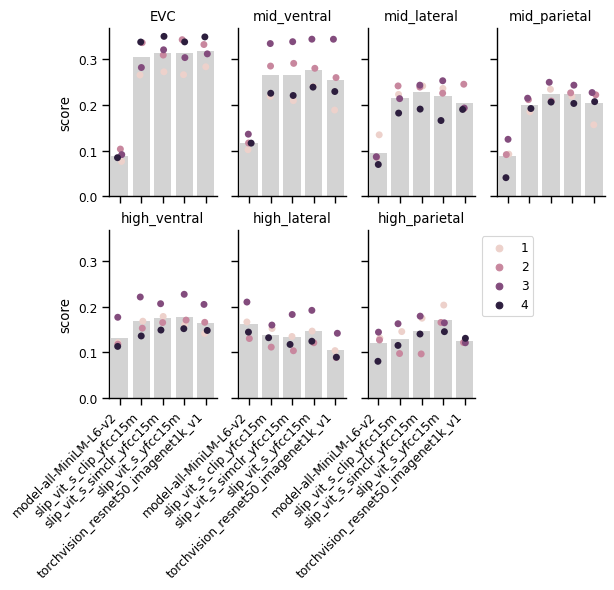

In [6]:
sns.set_context(context='paper')
_, axes = plt.subplots(2, 4, sharex=True, sharey=True)
trim_axs(axes, len(streams))
axes = axes.flatten()
stream_group = max_scores.groupby('stream_name')
models = max_scores.model_uid.unique()
for ax, (stream, stream_df) in zip(axes, stream_group):
   sns.barplot(x='model_uid', y='score',
                  data=stream_df, ax=ax,
                  color='lightgray', errorbar=None)
   sns.stripplot(x='model_uid', y='score',
                  hue='subj_id', dodge=False,
                  data=stream_df, ax=ax)
   if stream not in ['EVC', 'high_ventral']:
         ax.set_ylabel('')
   ax.spines['top'].set_visible(False)
   ax.spines['right'].set_visible(False)
   ax.set_xticklabels(models, rotation=45, ha='right')
   ax.set_title(stream)
   ax.set_xlabel('')
   if stream != 'high_parietal':
      ax.legend().set_visible(False)
   else:
      ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
# plt.tight_layout()

## SBERT perturbation experiments

In [7]:
perturbations = ['none', 'corrected_unmasked', 'shuffle_sentence', 
                'mask_all_nouns', 'mask_all_verbs',
                'mask_main_subjects', 'mask_main_verb_phrase', 
                'mask_direct_objects', 'mask_prep_phrases']

In [9]:
scores = []
for perturb in perturbations:
    file = f'{interim_dir}/LLMEncoding/model-all-MiniLM-L6-v2_perturbation-{perturb}.csv'
    df = pd.read_csv(file)
    df['perturbation'] = perturb
    scores.append(df)
    
scores = pd.concat(scores).reset_index(drop=True)
scores = scores[scores['stream_name'] != 'none'].reset_index(drop=True)
scores['model_layer_index'] = scores.model_layer_index.astype('str')
scores.set_index(['perturbation', 'model_layer_index', 'stream_name'], inplace=True)
scores.sort_index(inplace=True)
scores.head()

model_layer  subj_id  \
perturbation       model_layer_index stream_name                           
corrected_unmasked 1                 EVC           BertModel-S1        1   
                                     EVC           BertModel-S1        2   
                                     EVC           BertModel-S1        3   
                                     EVC           BertModel-S1        4   
                                     high_lateral  BertModel-S1        1   

                                                      score method  
perturbation       model_layer_index stream_name                    
corrected_unmasked 1                 EVC           0.045357  ridge  
                                     EVC           0.096012  ridge  
                                     EVC           0.068637  ridge  
                                     EVC           0.054093  ridge  
                                     high_lateral  0.134146  ridge

In [10]:
avg_scores = scores.reset_index().groupby(['perturbation', 'model_layer_index', 'stream_name']).mean().reset_index()
iter_scores = avg_scores.groupby(['perturbation', 'stream_name'])
max_scores = []
for (model_uid, stream), stream_df in iter_scores:
    idx = stream_df['score'].idxmax()
    score = tuple(stream_df.loc[idx, ['perturbation', 'model_layer_index', 'stream_name']].to_list())
    max_scores.append(scores.loc[score])
max_scores = pd.concat(max_scores).reset_index()
max_scores.head()

/var/folders/bp/2lmtx6qs4rzbksq18mtrbrjsfr_flb/T/ipykernel_24860/37540273.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avg_scores = scores.reset_index().groupby(['perturbation', 'model_layer_index', 'stream_name']).mean().reset_index()


,perturbation,model_layer_index,stream_name,model_layer,subj_id,score,method
0,corrected_unmasked,91,EVC,LayerNorm-6-35,1,0.076571,ridge
1,corrected_unmasked,91,EVC,LayerNorm-6-35,2,0.103687,ridge
2,corrected_unmasked,91,EVC,LayerNorm-6-35,3,0.091580,ridge
3,corrected_unmasked,91,EVC,LayerNorm-6-35,4,0.084788,ridge
4,corrected_unmasked,92,high_lateral,BertIntermediate-4-14,1,0.166583,ridge


In [11]:
cat_type = pd.CategoricalDtype(categories=streams, ordered=True)
max_scores['stream_name'] = max_scores['stream_name'].astype(cat_type)

cat_type = pd.CategoricalDtype(categories=perturbations, ordered=True)
max_scores['perturbation'] = max_scores['perturbation'].astype(cat_type)

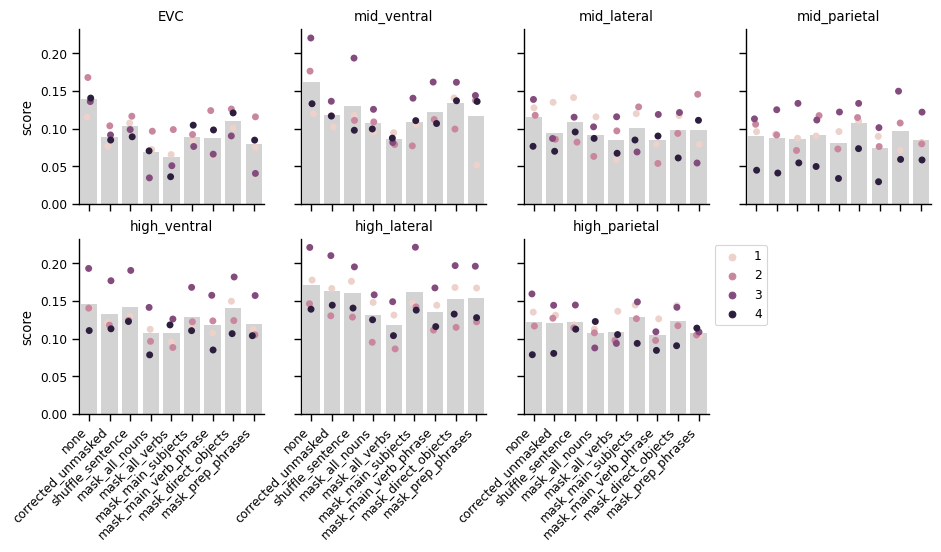

In [15]:
sns.set_context(context='paper')
_, axes = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(11,5))
trim_axs(axes, len(streams))
axes = axes.flatten()
stream_group = max_scores.groupby('stream_name')
for ax, (stream, stream_df) in zip(axes, stream_group):
   sns.barplot(x='perturbation', y='score',
                  data=stream_df, ax=ax,
                  color='lightgray', errorbar=None)
   sns.stripplot(x='perturbation', y='score',
                  hue='subj_id', dodge=False,
                  data=stream_df, ax=ax)
   if stream not in ['EVC', 'high_ventral']:
         ax.set_ylabel('')
   ax.spines['top'].set_visible(False)
   ax.spines['right'].set_visible(False)
   ax.set_xticklabels(perturbations, rotation=45, ha='right')
   ax.set_title(stream)
   ax.set_xlabel('')
   if stream != 'high_parietal':
      ax.legend().set_visible(False)
   else:
      ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
# plt.tight_layout()